In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import StepLR

In [4]:
# use path if the file is open using the github repository
# path = '../dataset/cleaned_data.csv'

path = "/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv"
data = pd.read_csv(path)
print(data.head())

                                                text  generated
0  carfree cities become subject increasing inter...          1
1  car free cities carfree cities concept gaining...          1
2  sustainable urban future carfree cities emergi...          1
3  pioneering sustainable urban living era marked...          1
4  path sustainable urban living age rapid urbani...          1


In [5]:
data['text'].isna().sum()

1

In [6]:
data['text'] = data['text'].fillna('')

In [7]:
data['text'].isna().sum()

0

In [8]:
data['generated'].isna().sum()

0

<function matplotlib.pyplot.show(close=None, block=None)>

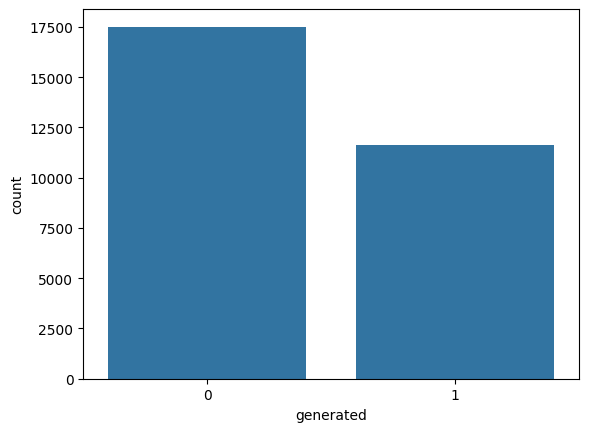

In [9]:
sns.countplot(x=data['generated'])
plt.show

In [10]:
def balance_labels(df, label_column='generated'):
    label_counts=df[label_column].value_counts()
    max_count=label_counts.max()

    balanced_df=pd.DataFrame()

    for label, count in label_counts.items():
        label_subset = df[df[label_column]==label]
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)

    return balanced_df

In [11]:
data=balance_labels(data)

<function matplotlib.pyplot.show(close=None, block=None)>

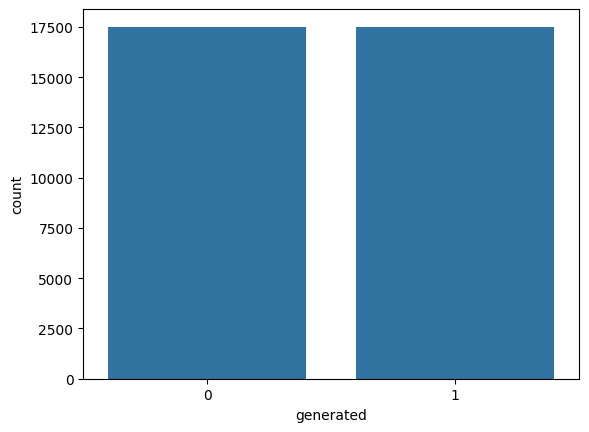

In [12]:
sns.countplot(x=data['generated'])
plt.show

In [18]:
X = data['text'].values
y = data['generated'].values

In [19]:
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size= 0.2, random_state= 42)

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Tokenize the text data
def encode_texts(texts, tokenizer, max_length=512):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=max_length
    )

train_encodings = encode_texts(X_train, tokenizer)
val_encodings = encode_texts(X_val, tokenizer)

# Create TensorDatasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val))

In [22]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # Assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Training Loss: 0.0562
Epoch 2/3, Training Loss: 0.0096
Epoch 3/3, Training Loss: 0.0020
Confusion Matrix:
[[3467    5]
 [   4 3528]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3472
           1       1.00      1.00      1.00      3532

    accuracy                           1.00      7004
   macro avg       1.00      1.00      1.00      7004
weighted avg       1.00      1.00      1.00      7004

Accuracy: 0.9987


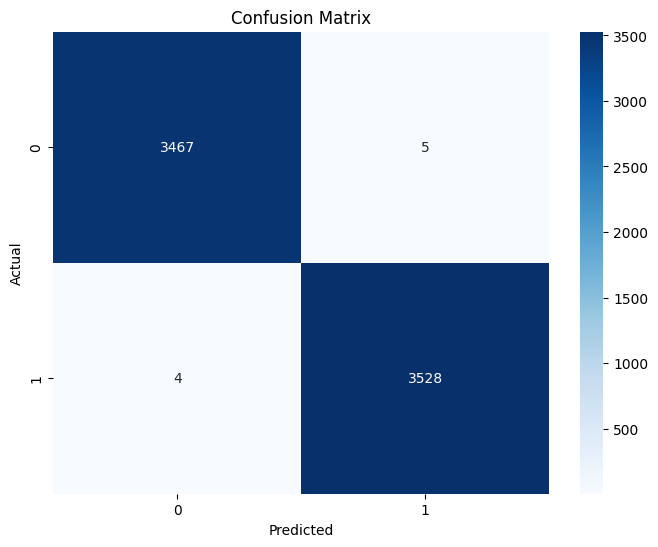

In [23]:
# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

# Evaluation loop
model.eval()
all_predictions, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        outputs = model(b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_predictions)
class_report = classification_report(all_labels, all_predictions)
accuracy = np.mean(all_predictions == all_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print(f'Accuracy: {accuracy:.4f}')

# Ploting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/RoBERTa_model.pt')

In [25]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameter grid
param_grid = {
    'learning_rate': [1e-5, 5e-5, 1e-4],
    'batch_size': [8, 16, 32],
    'epochs': [3, 4, 5]
}

grid = ParameterGrid(param_grid)


In [32]:
def train_and_evaluate(learning_rate, batch_size, epochs):
    # Initialize model, optimizer, and scheduler
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

    # Move model to the device
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            # Move batch to the device
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Evaluation loop
    model.eval()
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            # Move batch to the device
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            outputs = model(b_input_ids, attention_mask=b_attn_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions)
    accuracy = np.mean(all_predictions == all_labels)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    print(f'Accuracy: {accuracy:.4f}')

    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

In [33]:
best_accuracy = 0
best_params = {}

for params in grid:
    print(f"Testing params: {params}")
    accuracy = train_and_evaluate(
        learning_rate=params['learning_rate'],
        batch_size=params['batch_size'],
        epochs=params['epochs']
    )

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.4f}")

Testing params: {'batch_size': 8, 'epochs': 3, 'learning_rate': 1e-05}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 